In [1]:
import os 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar, RichProgressBar
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.functional import accuracy

seed_everything(7)

PATH_DATASETS = './data'
BATCH_SIZE = 350 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)
VALID_SIZE=0.1
CURRENT_PATH = globals()['_dh'][0]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Global seed set to 7



### 1. Load and normalize CIFAR10

In [2]:
class Cifar10AlbuDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            image = self.transform(image=np.asarray(image))["image"] # the result of albumentations is a dictionary

        return image, label

train_transform =  A.Compose([
    A.Sequential([
    A.PadIfNeeded(
        min_height=32+8,
        min_width=32+8,
    ),
    A.RandomCrop(
        height=32,
        width=32
    )], p=1.0), # work as the randomcrop in torchvision
    A.HorizontalFlip(),
    A.Cutout(num_holes=2, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    A.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
    ),
    ToTensorV2()
])

eval_transform =  A.Compose([
    A.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]],
    ),
    ToTensorV2()
])

train_dataset = Cifar10AlbuDataset(
    root=PATH_DATASETS, train=True,
    download=True, transform=train_transform,
)

valid_dataset = Cifar10AlbuDataset(
    root=PATH_DATASETS, train=True,
    download=True, transform=eval_transform,
)

test_dataset = Cifar10AlbuDataset(
    root=PATH_DATASETS, train=False,
    download=True, transform=eval_transform,
)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(VALID_SIZE * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
    num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, sampler=valid_sampler,
    num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')    

/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Files already downloaded and verified


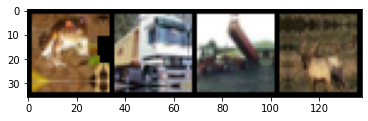

frog  truck truck deer 


In [3]:
demo_train_transform =  A.Compose([
    A.Sequential([
    A.PadIfNeeded(
        min_height=32+8,
        min_width=32+8,
    ),
    A.RandomCrop(
        height=32,
        width=32
    )], p=1.0),
    A.HorizontalFlip(),
    A.Cutout(num_holes=2, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    ToTensorV2()
])

demo_train_dataset = Cifar10AlbuDataset(
    root=PATH_DATASETS, train=True,
    download=True, transform=demo_train_transform,
)

demo_train_loader = torch.utils.data.DataLoader(
    demo_train_dataset, batch_size=4, num_workers=NUM_WORKERS)

# get some random training images
dataiter = iter(demo_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 2. Define a Convolutional Neural Network



In [4]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

### 3. Define a Loss function and optimizer



In [5]:
class ResNet(LightningModule):
    def __init__(self, lr=0.005):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.99), weight_decay=5e-4)
        return optimizer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /workspace/CIFAR10_lightning/.lr_find_d9ee6768-dbc7-4ac8-8b0c-134bfa620c21.ckpt


0.000630957344480193


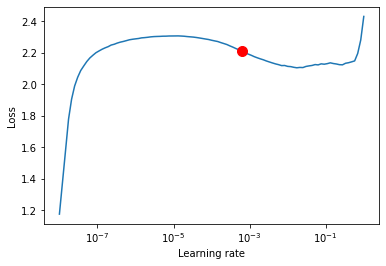

In [6]:
tune_model = ResNet()

trainer = Trainer(
    accelerator="gpu",
    devices=1,
)

lr_finder = trainer.tuner.lr_find(tune_model, train_loader, valid_loader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
print(lr_finder.suggestion())

In [7]:
TRIAL_NUM = 2

model = ResNet(lr=lr_finder.suggestion())

ckpt_dir = os.path.join(CURRENT_PATH, f"cifar10_ckpt/trial_{TRIAL_NUM}")
checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    monitor="val_acc",
    mode="max",
    dirpath=ckpt_dir,
    filename="cifar10-{epoch:02d}-{val_acc:.3f}",
)


trainer = Trainer(
    max_epochs=70,
    accelerator="gpu",
    devices=1,
    logger=CSVLogger(save_dir=os.path.join(CURRENT_PATH, f"cifar10_logs/trial_{TRIAL_NUM}")),
    callbacks=[checkpoint_callback, LearningRateMonitor(logging_interval="step"), RichProgressBar()],
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 4. Train the network

In [8]:
trainer.fit(model, train_loader, valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ ResNet │ 11.2 M │
└───┴───────┴────────┴────────┘

Trainable params: 11.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.2 M                                                                                               
Total estimated model params size (MB): 44

Output()

`Trainer.fit` stopped: `max_epochs=70` reached.


### 5. Test the network on the test data

Files already downloaded and verified


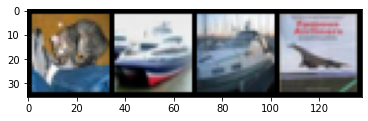

GroundTruth:  cat   ship  ship  plane


In [9]:
demo_test_transform =  ToTensorV2()

demo_test_dataset = Cifar10AlbuDataset(
    root=PATH_DATASETS, train=False, download=True, transform=demo_test_transform)

demo_test_loader = torch.utils.data.DataLoader(
    demo_test_dataset, batch_size=4, num_workers=NUM_WORKERS)

# get some random training images
dataiter = iter(demo_test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Let's load back in our saved model:



Okay, now let us see what the neural network thinks these examples above are:



In [10]:
best_ckpt_name= max(os.listdir(ckpt_dir), key=lambda x: float(x.split('=')[-1][:5]))

net = ResNet.load_from_checkpoint(os.path.join(ckpt_dir, best_ckpt_name))
net.eval()

dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [11]:
predicted = torch.argmax(outputs, dim=1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Let's look at how the network performs on the whole dataset.



In [12]:
correct = 0
total = len(test_dataset)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        predicted = torch.argmax(outputs, dim=1)

        correct += torch.sum(predicted == labels)
Accuracy = correct / total
print(f'Accuracy of the network on the 10000 test images: {Accuracy*100} %')

Accuracy of the network on the 10000 test images: 90.79000091552734 %


How good is the accuracy? Can you get more than 60%?

EXTRA: print the classification performance per class

In [13]:
total_by_class = {i: 0 for i in range(10)}
correct_by_class = {i: 0 for i in range(10)}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        predicted = torch.argmax(outputs, dim=1)

        for i in range(len(labels)):
            total_by_class[int(labels[i])] += 1
            if predicted[i] == labels[i]:
                correct_by_class[int(labels[i])] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * correct_by_class[i] / total_by_class[i]} %')

Accuracy of plane : 91.9 %
Accuracy of car   : 95.7 %
Accuracy of bird  : 83.9 %
Accuracy of cat   : 85.5 %
Accuracy of deer  : 88.8 %
Accuracy of dog   : 88.1 %
Accuracy of frog  : 96.0 %
Accuracy of horse : 93.5 %
Accuracy of ship  : 91.9 %
Accuracy of truck : 92.6 %
